In [1]:
# Calculate vflood for HGM given file input
import geopandas as gpd
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape
from rasterio.plot import show
import numpy as np

In [2]:
savefile = 'exampleprojects'

workspace = r'D:\gis\projects\YazooHGM\exampleprojects'
foi = os.path.join(workspace, 'examples.shp')


foi = gpd.read_file(foi).to_crs(5070)
foi['uid'] = foi.index.map(hash)

pv = os.path.join(workspace, 'Yazoo_PNV.shp')

pv = gpd.read_file(pv).to_crs(5070)

flood = os.path.join(workspace, 'HGM_5year.tif')

In [3]:
flood = rasterio.open(flood)
flood, flood_transform =rasterio.mask.mask(flood, foi.dissolve().geometry, crop=True)

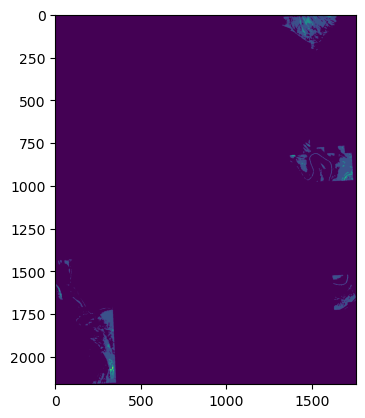

<Axes: >

In [4]:
show(flood)

In [5]:
shapes = rasterio.features.shapes(flood[0], transform=flood_transform, mask=flood[0] <=5)
geoms = []
values = []

for geom,value in shapes:
    geoms.append(shape(geom))
    values.append(value)
# Create a GeoDataFrame from the vector polygons
#gdf_vector = gpd.GeoDataFrame({'geometry': [shape(geom) for geom, value in shapes]})
flood_vector = gpd.GeoDataFrame({'geometry': geoms, 'value': values})
flood_vector = flood_vector.set_crs(5070)

In [6]:
foipv = gpd.overlay(foi, pv, how='intersection')

In [7]:
foipv['veg']=foipv['HGM'].str.split('-', expand=True)[0]

In [8]:
foipv = foipv.dissolve(by=['uid', 'veg'])

In [9]:
foiflood = gpd.sjoin(foipv, flood_vector, how='left', predicate='intersects')

In [10]:
#['flats', 'backwater', 'overbank', 'isolated', 'connected']
foiflood['vegtype'] = np.select(
    [
        foiflood['HGM'].str.contains('F-'), 
        foiflood['HGM'].str.contains('RB'),
        foiflood['HGM'].str.contains('RO'),
        foiflood['HGM'].str.contains('D-3'),
        foiflood['HGM'].str.contains('D-4'),
        foiflood['HGM'].str.contains('D-1'),
        foiflood['HGM'].str.contains('D-2')
    ], 
    ['flats', 'backwater', 'overbank','isolated', 'isolated', 'connected', 'connected'], 
    default='Unknown'
)
foiflood

geometry           Name  \
uid veg                                                                     
0   D    POLYGON Z ((480655.363 1077853.829 0.000, 4807...  HGM example 1   
    D    POLYGON Z ((480655.363 1077853.829 0.000, 4807...  HGM example 1   
    F    MULTIPOLYGON Z (((481900.614 1076480.750 0.000...  HGM example 1   
    F    MULTIPOLYGON Z (((481900.614 1076480.750 0.000...  HGM example 1   
    F    MULTIPOLYGON Z (((481900.614 1076480.750 0.000...  HGM example 1   
...                                                    ...            ...   
4   RB   MULTIPOLYGON Z (((469239.019 1057236.979 0.000...  HGM example 5   
    RB   MULTIPOLYGON Z (((469239.019 1057236.979 0.000...  HGM example 5   
    RB   MULTIPOLYGON Z (((469239.019 1057236.979 0.000...  HGM example 5   
    RB   MULTIPOLYGON Z (((469239.019 1057236.979 0.000...  HGM example 5   
    RB   MULTIPOLYGON Z (((469239.019 1057236.979 0.000...  HGM example 5   

          HGM    Shape_Leng    Shape_Area  index_right  value    vegtype  
uid veg                                                                   
0   D     D-3  1.458705e+07  4.712214e+08         1595    0.0   isolated  
    D     D-3  1.458705e+07  4.712214e+08          273    1.0   isolated  
    F     F-2  1.127546e+07  1.814280e+09         1595    0.0      flats  
    F     F-2  1.127546e+07  1.814280e+09          289    1.0      flats  
    F     F-2  1.127546e+07  1.814280e+09          161    1.0      flats  
...       ...           ...           ...          ...    ...        ...  
4   RB   RB-1  3.711193e+06  1.647606e+08         1312    2.0  backwater  
    RB   RB-1  3.711193e+06  1.647606e+08         1301    0.0  backwater  
    RB   RB-1  3.711193e+06  1.647606e+08         1292    0.0  backwater  
    RB   RB-1  3.711193e+06  1.647606e+08         1286    0.0  backwater  
    RB   RB-1  3.711193e+06  1.647606e+08         1595    0.0  backwater  

[1725 rows x 8 columns]

In [11]:
foiflood = foiflood.dissolve(by=['uid', 'vegtype'], aggfunc={'value':'mean'})
foiflood = foiflood.reset_index()
foiflood = foiflood[foiflood['vegtype']!='Unknown']

In [12]:
foiflood = foiflood.rename(columns={'value':'vfreq'})
foiflood.to_parquet(os.path.join(workspace,savefile + '_vfreq.parquet'))